<a href="https://colab.research.google.com/github/byambaa1982/micro_project/blob/main/micro_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive from Google Colab using Google Secrect Key

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [22]:
from google.colab import auth
auth.authenticate_user()
project_id = 'twittersheet-275317'

In [149]:
os.chdir("/content/gdrive/My Drive/upwork/david") 
!ls

 david_test_sheet.gsheet  'Lab data definitions samples.gsheet'


In [31]:
import pandas as pd
from datetime import datetime
import re
import os
import glob
from collections import Counter
import json
import numpy as np
from sqlalchemy import create_engine
import psycopg2 
import io
from io import StringIO
from io import BytesIO
import requests
import pandas_gbq
from google.cloud import storage

import gspread
from oauth2client.client import GoogleCredentials
from oauth2client.service_account import ServiceAccountCredentials 

In [3]:
!pip install psycopg2-binary

     |████████████████████████████████| 3.0 MB 4.0 MB/s 


In [4]:
import psycopg2 as pg
import pandas.io.sql as psql

# Install Postgres and create database

In [9]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../0-cron_3.0pl1-128.1ubuntu1_amd64.deb ...
Unpacking cron (3.0pl1-128.1ubuntu1) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../1-logrotate_3.11.0-0.1ubuntu1_amd64.deb ...
Unpacking logrotate (3.11.0-0.1ubuntu1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../2-netbase_5.4_all.deb ...
Unpacking netbase (5.4) ...
Selecting previously unselected pac

In [10]:
# Setup a database with name `tfio_demo` to be used
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE micro_project;'

CREATE DATABASE


# Create connection to database

In [11]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(cursor.fetchall())
# for table in cursor.fetchall():
#   print(table)
cursor.close()
conn.close()

[]


# Create table in the Postgres database

In [65]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
cursor.execute('CREATE TABLE lab_data (service_week varchar, service_year varchar, service_yearmonth varchar, betos_cd varchar, betos_desc varchar, pos_cd varchar, pos_desc varchar, spec_cd varchar, spec_desc varchar, paid_amount varchar, utilization varchar);')  
conn.commit()
conn.close()

In [87]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
cursor.execute('CREATE TABLE lab_data_2 (service_week varchar, service_year varchar, service_yearmonth varchar, spec_desc varchar, paid_amount varchar, utilization varchar);')  
conn.commit()
conn.close()

# Print table names created in the database

In [101]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(cursor.fetchall())
# for table in cursor.fetchall():
#   print(table)
cursor.close()
conn.close()

[('test',), ('test_table',), ('test_table_2',), ('lab_data',), ('lab_data_2',)]


In [102]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
table_names=cursor.fetchall()
print(cursor.fetchall())
# for table in cursor.fetchall():
#   print(table)
cursor.close()
conn.close()

[]


In [110]:
[table_names[i][0] for i in range(len(table_names))]

['test', 'test_table', 'test_table_2', 'lab_data', 'lab_data_2']

In [111]:
def read_psql(table):
  queries=''' SELECT * FROM `'''+table
  df = pd.io.gbq.read_gbq(queries, project_id=project_id, dialect='standard')
  return df

# Read Data from Google sheets and inject it into Postgres table

In [156]:
# DESC: Get Authentification for GoogleSheet
#   @param: None
#   @post:
#       returns Dataframe of company_name, cleaned and company_id
def get_client():
  scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
  client = storage.Client()
  blobs=[]
  for blob in client.list_blobs('euro_indicators', prefix='creds'):
      # print(str(blob.name))
    blobs.append(blob)
    print(blob)

  blobs[1].download_to_filename('/tmp/creds.json')
  creds = ServiceAccountCredentials.from_json_keyfile_name('/tmp/creds.json',scope)

  client = gspread.authorize(creds)

  return client

def get_users_informations():
 
  client = get_client()

  all_users = client.open("david_test_sheet").worksheet('test')
  users = pd.DataFrame(all_users.get_all_values())
  users.columns=pd.Series(users.loc[0])
  users = users.drop([0])
  return users

In [157]:
os.environ["GCLOUD_PROJECT"]='twittersheet-275317'
df=get_users_informations()

<Blob: euro_indicators, creds/, 1625172096504248>
<Blob: euro_indicators, creds/creds.json, 1637637102972772>


In [158]:
df.head()

,service_week,service_year,service_yearmonth,service_date,betos_cd,betos_desc,pos_cd,pos_desc,spec_cd,spec_desc,paid_amount,utilization,,price
1,2017-01,2017,2017-01-01,"Jan 2, 2017",T1A,Lab tests - routine venipuncture (non Medicare...,11,Office,6,Physician/Cardiovascular Disease (Cardiology),$2.94,1,,
2,2017-01,2017,2017-01-01,"Jan 2, 2017",T1G,Lab tests - other (Medicare fee schedule),22,On Campus- Outpatient Hospital,22,Physician/Pathology,$0.00,1,,
3,2017-01,2017,2017-01-01,"Jan 2, 2017",T1H,Lab tests - other (non-Medicare fee schedule),81,Independent Laboratory,69,Clinical Laboratory,$19.18,1,,
4,2017-01,2017,2017-01-01,"Jan 3, 2017",T1A,Lab tests - routine venipuncture (non Medicare...,11,Office,10,Physician/Gastroenterology,$5.88,2,,
5,2017-01,2017,2017-01-01,"Jan 3, 2017",T1A,Lab tests - routine venipuncture (non Medicare...,11,Office,11,Physician/Internal Medicine,$5.88,2,,2.94


In [59]:
type(df.service_week[2])

str

In [53]:
df.columns

Index(['service_week', 'service_year', 'service_yearmonth', 'service_date',
       'betos_cd', 'betos_desc', 'pos_cd', 'pos_desc', 'spec_cd', 'spec_desc',
       'paid_amount', 'utilization', '', 'price'],
      dtype='object', name=0)

In [91]:
df1=df[['service_week', 'service_year', 'service_yearmonth', 'spec_desc','paid_amount', 'utilization']]
#'service_week varchar, service_year varchar, service_yearmonth varchar, spec_desc varchar, paid_amount varchar, utilization varchar'
cols=df1.columns.to_list()
for col in cols:
  df1[str(col)]=df1[str(col)].map(lambda x:str(x))
  df1=df1.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [93]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
output = io.StringIO()
df1.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
contents = output.getvalue()

cursor.copy_from(output, 'lab_data_2', null="") # null values become ''

conn.commit()

# pull data from database

In [97]:
# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table
# Store the data as a variable
test = create_pandas_table("SELECT * FROM lab_data_2")
test

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
# cur.close()
conn.close()

In [129]:
conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
cursor = conn.cursor()
database = conn
# sql_query="SELECT * FROM lab_data_2"
table_name='lab_data_2'
sql_query='''SELECT * FROM '''+table_name
df = pd.read_sql_query(sql_query, database)
conn.close()

In [132]:
# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_table(table_name):
  conn = pg.connect(
    host='localhost', database='micro_project',
    user='postgres', password='postgres')
  cursor = conn.cursor()
  database = conn
  # sql_query="SELECT * FROM lab_data_2"
  sql_query='''SELECT * FROM '''+table_name
  df = pd.read_sql_query(sql_query, database)
  conn.close()
  return df

# Loop each tables and print infos

In [145]:
# table_name='lab_data_2'
table_names=['test', 'test_table', 'test_table_2', 'lab_data', 'lab_data_2']
for table_name in table_names:
  print("--- This table: {} ---".format(table_name))
  test=create_pandas_table(table_name)
  print("Total of columns: {}, total of rows: {}".format(test.shape[1],test.shape[0]))
  print("columns names: {}".format(test.columns.to_list()))
  names=test.columns.to_list()
  for name in names:
    print("columns data type: {}".format(test['service_week'].dtype))

--- This table: test ---
Total of columns: 0, total of rows: 0
columns names: []
--- This table: test_table ---
Total of columns: 3, total of rows: 0
columns names: ['service_week', 'service_year', 'service_yearmonth']
columns data type: object
columns data type: object
columns data type: object
--- This table: test_table_2 ---
Total of columns: 3, total of rows: 33
columns names: ['service_week', 'service_year', 'service_yearmonth']
columns data type: object
columns data type: object
columns data type: object
--- This table: lab_data ---
Total of columns: 11, total of rows: 0
columns names: ['service_week', 'service_year', 'service_yearmonth', 'betos_cd', 'betos_desc', 'pos_cd', 'pos_desc', 'spec_cd', 'spec_desc', 'paid_amount', 'utilization']
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns data type: object
columns dat

# Describe table before Cleaning

In [146]:
table_name='lab_data_2'
test=create_pandas_table(table_name)
test.describe()

,service_week,service_year,service_yearmonth,spec_desc,paid_amount,utilization
count,33,33,33,33,33,33
unique,1,1,1,13,26,6
top,2017-01,2017,2017-01-01,Physician/Infectious Disease,$2.94,1
freq,33,33,33,5,3,16


# After Cleaning 

In [150]:
def point_str_to_float(a_str):
    if type(a_str)==float:
      return a_str
    elif type(a_str)==int:
      return float(a_str)
    elif type(a_str)==np.nan:
      return 0
    elif a_str=="":
      return 0
    else:
      a_num=re.findall(r"[-+]?\d*\.\d+|\d+", a_str)
      try:
        a_num=float(a_num[0])
        return a_num
      except:
        return 0

In [153]:
test.paid_amount=test.paid_amount.map(lambda x: point_str_to_float(x))
test.spec_desc=test.spec_desc.map(lambda x: point_str_to_float(x))

In [154]:
test.describe()

,spec_desc,paid_amount
count,33.0,33.000000
mean,0.0,39.068182
std,0.0,98.198734
min,0.0,0.000000
25%,0.0,4.260000
50%,0.0,11.470000
75%,0.0,24.730000
max,0.0,558.440000


In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


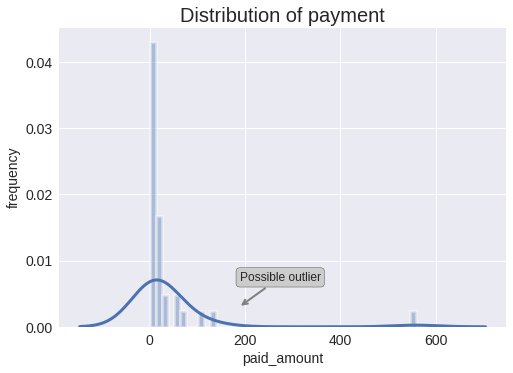

In [164]:
# histogram and kernel density estimation function of the variable height
ax = sns.distplot(test.paid_amount, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

# notation indicating a possible outlier
ax.annotate('Possible outlier', xy=(188,0.0030), xytext=(189,0.0070), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('paid_amount', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.title('Distribution of payment', fontsize=20);